# Sentinel-5P Level 2

Included air quality metrics:
- Methane (CH4) total column
- Sulphur Dioxide (SO2) total column
- UV Aerosol Index
- Formaldehyde (HCHO) total column
- Nitrogen Dioxide (NO2)
- Carbon Monoxide (CO) total column
- Cloud fraction, top pressure

No particulates but CH4, SO2, NO2 and CO would be correlated with cars I'd imagine

But... 'the absorbing aerosol index (AAI) can be used to determine the presence of UV-absorbing aerosols, such as dust and smoke'...but seemingly would need to derive to get specific particulate matter like PM10. Still good broad value

### groups: PRODUCT, METADATA

https://sentinel.esa.int/documents/247904/2474726/Sentinel-5P-Level-2-Product-User-Manual-Ozone-Total-Column

8 General structure of S5P/TROPOMI Level 2 files
This section gives an overview of the basic structure of all Sentinel 5 precursor level 2 files. In subsections 8.2 –
8.3 and sections 9 – 11 some details are provided on the background of the structure of the level 2 files of
Sentinel 5 precursor. A complete description of the variables in the O3 Total Column files is given in section 12.
Figure 3 gives a graphical representation of the generic structure of a TROPOMI Level 2 file. The outermost
layer is the file itself. Within the file different groups are used to organise the data and make it easier to find
what you are looking for. Within the file there are two groups: “PRODUCT” and “METADATA”. Both of these
groups contain sub-groups. The purpose of each group are discussed below.
PRODUCT The variables in this group will answer the questions what, when, where and how well. This
group stores the main data fields of the product, including the precision of the main parameters, latitude,
longitude and variable to determine the observation time and the dimensions needed for the data (a time
reference dimension (time), the number of measurements in the granule (scanline), the number of spectra
in a measurement (ground_pixel) and depending on the product also a pressure-level dimension, or
state-vector dimensions). The “qa_value” parameter summarizes the processing flags into a continuous
value, giving a quality percentage: 100 % is the most optimal value, 0 % is a processing failure, in
between lies a continuum of values1.


In the ‘PRODUCT’ group a sub-group ‘SUPPORT_DATA’ can be found:
 - SUPPORT_DATA Additional data that is not directly needed for using and understanding the main data product is stored in subgroups of this group. The data in this group is further split up into the following sub groups:
 - GEOLOCATIONS Additional geolocation and geometry related fields, including the pixel boundar288 ies (pixel corners), viewing- and solar zenith angles, azimuth angles, and spacecraft location.
 - DETAILED_RESULTS Additional output, including state-vector elements that are not the main parameter(s), output describing the quality of the retrieval result, such as a χ2 value, and detailed processing flags.
 - INPUT_DATA Additional input data, such as meteorological input data, surface albedo values, surface altitude and other data that was used to derive the output. Note that input profile information is not stored here, but is available for download from elsewhere.

https://github.com/Sentinel-5P/data-on-s3/blob/master/DocsForAws/Sentinel5P_Description.md

# CARBON MONOXIDE (CO)

In [2]:
%%capture
!pip install xarray==0.20.2  #latest package 2022.6.0 doesn't work
!pip install s3fs
!pip install netcdf4
!pip install h5netcdf

!pip install geopandas --quiet
!pip install shapely --quiet
!pip install contextily --quiet

In [4]:
import s3fs
import h5netcdf
import netCDF4
import xarray as xr

import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import math

from shapely.geometry import Point, Polygon
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import contextily as cx

### LOOP THROUGH FOLDERS AND EXTRACT DATA

In [60]:
one_to_nine = ['01', '02', '03', '04', '05', '06', '07', '08', '09']
ten_to_32 = list(range(10, 32))
for i in ten_to_32:
    i = str(i)
ten_to_32_str = [str(i) for i in ten_to_32]
subfolder_list = one_to_nine + ten_to_32_str
print(subfolder_list)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


In [82]:
#reduce down to only looking at half a month
limit = math.ceil(len(subfolder_list)/2)
subfolder_list = subfolder_list[0:limit]
print(subfolder_list)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']


In [83]:
indices = [5, 6, 7, 8]   #take only keys at these indices from each subfolder, where we know london coverage appears
keys = []
for i in subfolder_list:
    bucket = 'meeo-s5p'
    subfolder = 'OFFL/L2__CO____/2022/06/' + i + '/'   #loop through June's subfolders

    conn = boto3.client('s3')
    #some folders e.g. 10 don't exist, continue loop when error for these non existent folders
    try:
        contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']
    except:
        continue
    
    temp_list = []
    for f in contents:
        temp_list.append(f['Key'])
    
    for index in range(len(temp_list)):
        if index in indices:
            keys.append(temp_list[index])
            
keys[0:4]

['OFFL/L2__CO____/2022/06/01/S5P_OFFL_L2__CO_____20220601T085512_20220601T103642_24005_02_020301_20220602T224512.nc',
 'OFFL/L2__CO____/2022/06/01/S5P_OFFL_L2__CO_____20220601T103642_20220601T121812_24006_02_020301_20220603T002447.nc',
 'OFFL/L2__CO____/2022/06/01/S5P_OFFL_L2__CO_____20220601T121812_20220601T135942_24007_02_020301_20220603T020518.nc',
 'OFFL/L2__CO____/2022/06/01/S5P_OFFL_L2__CO_____20220601T135942_20220601T154112_24008_02_020301_20220603T034452.nc']

In [105]:
len(keys)

60

In [86]:
#find .nc file where filtering does not result in 0 longitude or latitudes (or co)

uk_keys = []
count = 0
uk_df = pd.DataFrame() 
for i in keys:
    #extract data from netcdf5 as xarray dataset
    fs = s3fs.S3FileSystem(anon=True)
    f = fs.open('s3://meeo-s5p/' + i)
    ds = xr.open_dataset(f, engine='h5netcdf', group = 'PRODUCT')

    #collapse 3 dimensions
    ds = ds.sel(time=ds.time[0])
    ds = ds.sel(layer='500')
    ds = ds.drop_dims('corner')
    #only high quality data
    #ds = ds.where(ds.qa_value > 0.5, drop = True)
    #target parameter
    ds = ds[['carbonmonoxide_total_column_corrected', 'qa_value']]   #keep qa value too, can filter later if want
    #uk filter
    #ds = ds.where((ds.latitude > 50.10319) & (ds.latitude < 60.15456), drop = True)
    #ds = ds.where((ds.longitude > -7.64133) & (ds.longitude < 1.75159), drop = True)
    #london filter
    ds = ds.where((ds.latitude > 51.239405) & (ds.latitude < 51.737184), drop = True)
    ds = ds.where((ds.longitude > -0.625211) & (ds.longitude < 0.328289), drop = True)

    #drop nas along remaining dimensions - NO, for transparency of method, NAs will be dropped from dataframe than xarray
    #ds = ds.dropna('scanline', how='any')
    #ds = ds.dropna('ground_pixel', how='any')
    
    count += 1
    
    df = ds.to_dataframe()
    df = df.reset_index()
    df = df.drop(['scanline', 'ground_pixel'], axis = 1)
    df = df.dropna(how = 'any')
    
    if len(df) == 0:
        print(str(count) + '/' + str(len(keys)), '\t', '---> NONE FOUND')
        continue
    else:
        print(str(count) + '/' + str(len(keys)), '\t', '---> UK COVERAGE FOUND')
        #append to uk keys list
        uk_keys.append(i)
        #append to uk dataframe
        uk_df = uk_df.append(df)
        continue

1/60 	 ---> NONE FOUND
2/60 	 ---> UK COVERAGE FOUND
3/60 	 ---> UK COVERAGE FOUND
4/60 	 ---> NONE FOUND
5/60 	 ---> NONE FOUND
6/60 	 ---> NONE FOUND
7/60 	 ---> UK COVERAGE FOUND
8/60 	 ---> NONE FOUND
9/60 	 ---> NONE FOUND
10/60 	 ---> UK COVERAGE FOUND
11/60 	 ---> NONE FOUND
12/60 	 ---> NONE FOUND
13/60 	 ---> NONE FOUND
14/60 	 ---> UK COVERAGE FOUND
15/60 	 ---> UK COVERAGE FOUND
16/60 	 ---> NONE FOUND
17/60 	 ---> NONE FOUND
18/60 	 ---> NONE FOUND
19/60 	 ---> NONE FOUND
20/60 	 ---> NONE FOUND
21/60 	 ---> NONE FOUND
22/60 	 ---> UK COVERAGE FOUND
23/60 	 ---> UK COVERAGE FOUND
24/60 	 ---> NONE FOUND
25/60 	 ---> NONE FOUND
26/60 	 ---> UK COVERAGE FOUND
27/60 	 ---> UK COVERAGE FOUND
28/60 	 ---> NONE FOUND
29/60 	 ---> NONE FOUND
30/60 	 ---> UK COVERAGE FOUND
31/60 	 ---> NONE FOUND
32/60 	 ---> NONE FOUND
33/60 	 ---> UK COVERAGE FOUND
34/60 	 ---> NONE FOUND
35/60 	 ---> NONE FOUND
36/60 	 ---> NONE FOUND
37/60 	 ---> NONE FOUND
38/60 	 ---> UK COVERAGE FOUND
39/60 

In [ ]:
uk_df.head()

In [88]:
len(uk_df)

941

In [104]:
#persist dataframe to local csv file        
uk_df.to_csv('co_sentinel_01-16june.csv', index = False)

### MANUAL EDA OF DATA FOR METRIC (e.g. setup filters needed)

In [107]:
fs = s3fs.S3FileSystem(anon=True)

# Open with s3fs
f = fs.open('s3://meeo-s5p/OFFL/L2__CO____/2022/01/01/S5P_OFFL_L2__CO_____20220101T004639_20220101T022809_21858_02_020301_20220102T143525.nc')

# open xarray dataset
ds2 = xr.open_dataset(f, engine='h5netcdf', group = 'PRODUCT')   #or netcdf4

In [108]:
ds5 = ds2.copy()

In [111]:
ds5

<xarray.Dataset>
Dimensions:                                               (scanline: 4173, ground_pixel: 450, time: 1, corner: 4, polynomial_exponents: 6, intensity_offset_polynomial_exponents: 1, layer: 34, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

In [110]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877850
1877850


In [532]:
#filtering to 1 time essentially drops time dimension
ds5 = ds5.sel(time=ds5.time[0])

In [535]:
print(ds5.latitude.size)
print(ds5.longitude.size)

896980
896980


896980

In [533]:
ds5 = ds5.sel(layer='500')

In [535]:
print(ds5.latitude.size)
print(ds5.longitude.size)

896980
896980


896980

In [534]:
#only need scanline and ground_pixel dimensions for lon lat and co (see brackets)
ds5 = ds5.drop_dims('corner')

In [535]:
print(ds5.latitude.size)
print(ds5.longitude.size)

896980
896980


896980

In [536]:
ds5

<xarray.Dataset>
Dimensions:                                (scanline: 4172, ground_pixel: 215)
Coordinates:
  * scanline                               (scanline) float64 0.0 ... 4.171e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 214.0
    time                                   datetime64[ns] 2022-01-01
    layer                                  float32 500.0
    latitude                               (scanline, ground_pixel) float32 ...
    longitude                              (scanline, ground_pixel) float32 ...
Data variables:
    delta_time                             (scanline) datetime64[ns] ...
    time_utc                               (scanline) object ...
    qa_value                               (scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column            (scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column_precision  (scanline, ground_pixel) float32 ...
    carbonmonoxide_total_column_corrected  (scanline, ground_pixel) float32 ...

In [ ]:
#Recommend to ignore data with qa_value < 0.5 --> from data variable descriptor
#ds5 = ds5.where(ds5.qa_value > 0.5, drop = True)

In [538]:
print(ds5.latitude.size)
ds5.longitude.size

896980


896980

In [537]:
#filter by qa value then by co column so that dropping NAs (afterwards) only occurs for co column (retain as much as possible)
ds5 = ds5[['carbonmonoxide_total_column_corrected', 'qa_value']]

In [538]:
print(ds5.latitude.size)
ds5.longitude.size

896980


896980

In [540]:
#uk filter latitude, 500m is the lowest of the 50 layers
#ds5 = ds5.where((ds5.latitude > 50.10319) & (ds5.latitude < 60.15456), drop = True)
#ds5 = ds5.where((ds5.longitude > -7.64133) & (ds5.longitude < 1.75159), drop = True)

#london filter
ds5 = ds5.where((ds5.latitude > 51.239405) & (ds5.latitude < 51.737184), drop = True)
ds5 = ds5.where((ds5.longitude > -0.625211) & (ds5.longitude < 0.328289), drop = True)

In [541]:
print(ds5.latitude.size)
ds5.longitude.size

850


850

In [542]:
#BEST DROPPING NAS FROM DATAFRAME RATHER THAN XARRAY AS CLEARER WHATS BEING DONE

#drops NAs in this dimension
#will remove all NAs of co

#how ({"any", "all"}, default: "any") –
#any : if any NA values are present, drop that label
#all : if all values are NA, drop that label

#if any of longitude, latitude or co have null values, that data record becomes useless, so drop any

#ds5 = ds5.dropna('scanline', how='any')
#ds5 = ds5.dropna('ground_pixel', how='any')

In [544]:
ds5

<xarray.DataArray 'carbonmonoxide_total_column_corrected' (scanline: 170, ground_pixel: 5)>
array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
...
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 3.545e+03 3.546e+03 ... 3.713e+03 3.714e+03
  * ground_pixel  (ground_pixel) float64 204.0 205.0 206.0 207.0 208.0
    time          datetime64[ns] 2022-01-01
    layer         float32 500.0
    latitude      (scanline, ground_pixel) float32 51.14 51.12 ... 59.26 59.23
    longitude     (scanline, ground_pixel) float32 -0.4112 -0.07395 ... 0.3088
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             carbonmonoxide_tot...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

In [545]:
df = ds5.to_dataframe()

In [546]:
df.head()

time  layer   latitude  longitude  \
scanline ground_pixel                                           
3545.0   204.0        2022-01-01  500.0  51.136822  -0.411196   
         205.0        2022-01-01  500.0  51.119350  -0.073948   
         206.0        2022-01-01  500.0  51.100014   0.275387   
         207.0        2022-01-01  500.0  51.078640   0.637677   
         208.0        2022-01-01  500.0  51.055038   1.013891   

                       carbonmonoxide_total_column_corrected  
scanline ground_pixel                                         
3545.0   204.0                                           NaN  
         205.0                                           NaN  
         206.0                                           NaN  
         207.0                                           NaN  
         208.0                                           NaN

In [547]:
len(df)

850

In [548]:
df = df.reset_index()

In [549]:
df.head()

,scanline,ground_pixel,time,layer,latitude,longitude,carbonmonoxide_total_column_corrected
0,3545.0,204.0,2022-01-01,500.0,51.136822,-0.411196,NaN
1,3545.0,205.0,2022-01-01,500.0,51.119350,-0.073948,NaN
2,3545.0,206.0,2022-01-01,500.0,51.100014,0.275387,NaN
3,3545.0,207.0,2022-01-01,500.0,51.078640,0.637677,NaN
4,3545.0,208.0,2022-01-01,500.0,51.055038,1.013891,NaN


In [550]:
df.columns

Index(['scanline', 'ground_pixel', 'time', 'layer', 'latitude', 'longitude',
       'carbonmonoxide_total_column_corrected'],
      dtype='object')

In [551]:
df = df.drop(['scanline', 'ground_pixel'], axis = 1)
df.head()

,time,layer,latitude,longitude,carbonmonoxide_total_column_corrected
0,2022-01-01,500.0,51.136822,-0.411196,NaN
1,2022-01-01,500.0,51.119350,-0.073948,NaN
2,2022-01-01,500.0,51.100014,0.275387,NaN
3,2022-01-01,500.0,51.078640,0.637677,NaN
4,2022-01-01,500.0,51.055038,1.013891,NaN


In [553]:
print('Number of NAs:', df['carbonmonoxide_total_column_corrected'].isnull().sum())

Number of NAs: 850


In [554]:
df = df.dropna(how = 'any')

In [555]:
df.head()

,time,layer,latitude,longitude,carbonmonoxide_total_column_corrected


In [556]:
len(df)

0

In [41]:
df.duplicated().value_counts()

False    100
dtype: int64

### MAPPING LATITUDES AND LONGITUDES

In [90]:
#df = uk_df

In [93]:
lalo_data = df[['longitude', 'latitude']]
lalo_data.head()

,longitude,latitude
1027,0.067276,51.354122
1042,0.026450,51.397655
1056,-0.321801,51.279686
1057,-0.014448,51.441166
1071,-0.362949,51.323055
...,...,...
75,0.197790,51.634857
82,-0.310271,51.692589
83,-0.064127,51.688507
84,0.188415,51.683567


In [95]:
london_map = gpd.read_file(r'London-wards-2018/London-wards-2018_ESRI/London_Ward_CityMerged.shp')

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(lalo_data, geometry = geometry, crs = 4326)
#4326 is the go to CRS for GPS lat lon, need to set here so conversion to another is standardised as setting wrong CRS here means conversion (to_crs) will be wrong

london_map['geometry'] = london_map['geometry'].to_crs(epsg=3857)
gdf['geometry'] = gdf['geometry'].to_crs(epsg=3857)

In [100]:
def makeLayeredMap(*args):
    """This function accepts an arbitrary number of geodataframes, plots them on top of a Contextily basemap. 
    NOTE: Please edit the Plotting-section to specify parameters for the number of layers and the formatting of each layer.
    Output: Saved file and layered map for display."""
    
    # Convert the CRS for all layers to EPSG3857 to match Contextily
    args = list(map(lambda x: x.to_crs(epsg=3857), args))
    # Create figure
    fig, ax = plt.subplots(1, figsize=(20, 20))
    #Set aspect to equal
    ax.set_aspect('equal')
    
    # PLOTTING: Specify layers to plot how to format each layer (colours, transparency, etc.):
    # Layer 1:
    args[0].boundary.plot(ax=ax, color='blue', edgecolor='k', alpha=0.3, zorder=1)
    # Layer 2:
    args[1].plot(ax=ax, color='red', markersize=400, marker='*', zorder=2)
    # ADD LAYERS here as needed:
    #args[2].plot(ax=ax, color='black', alpha=0.3, zorder=3)
    
    # Contextily basemap:
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    
    # Turn off axis
    ax.axis('off')
    # Save as file
    fig.savefig('CO_sentinel_london_satellite.png', dpi=300)
    layered_map = plt.show()
    return(layered_map)
    #plt.show()

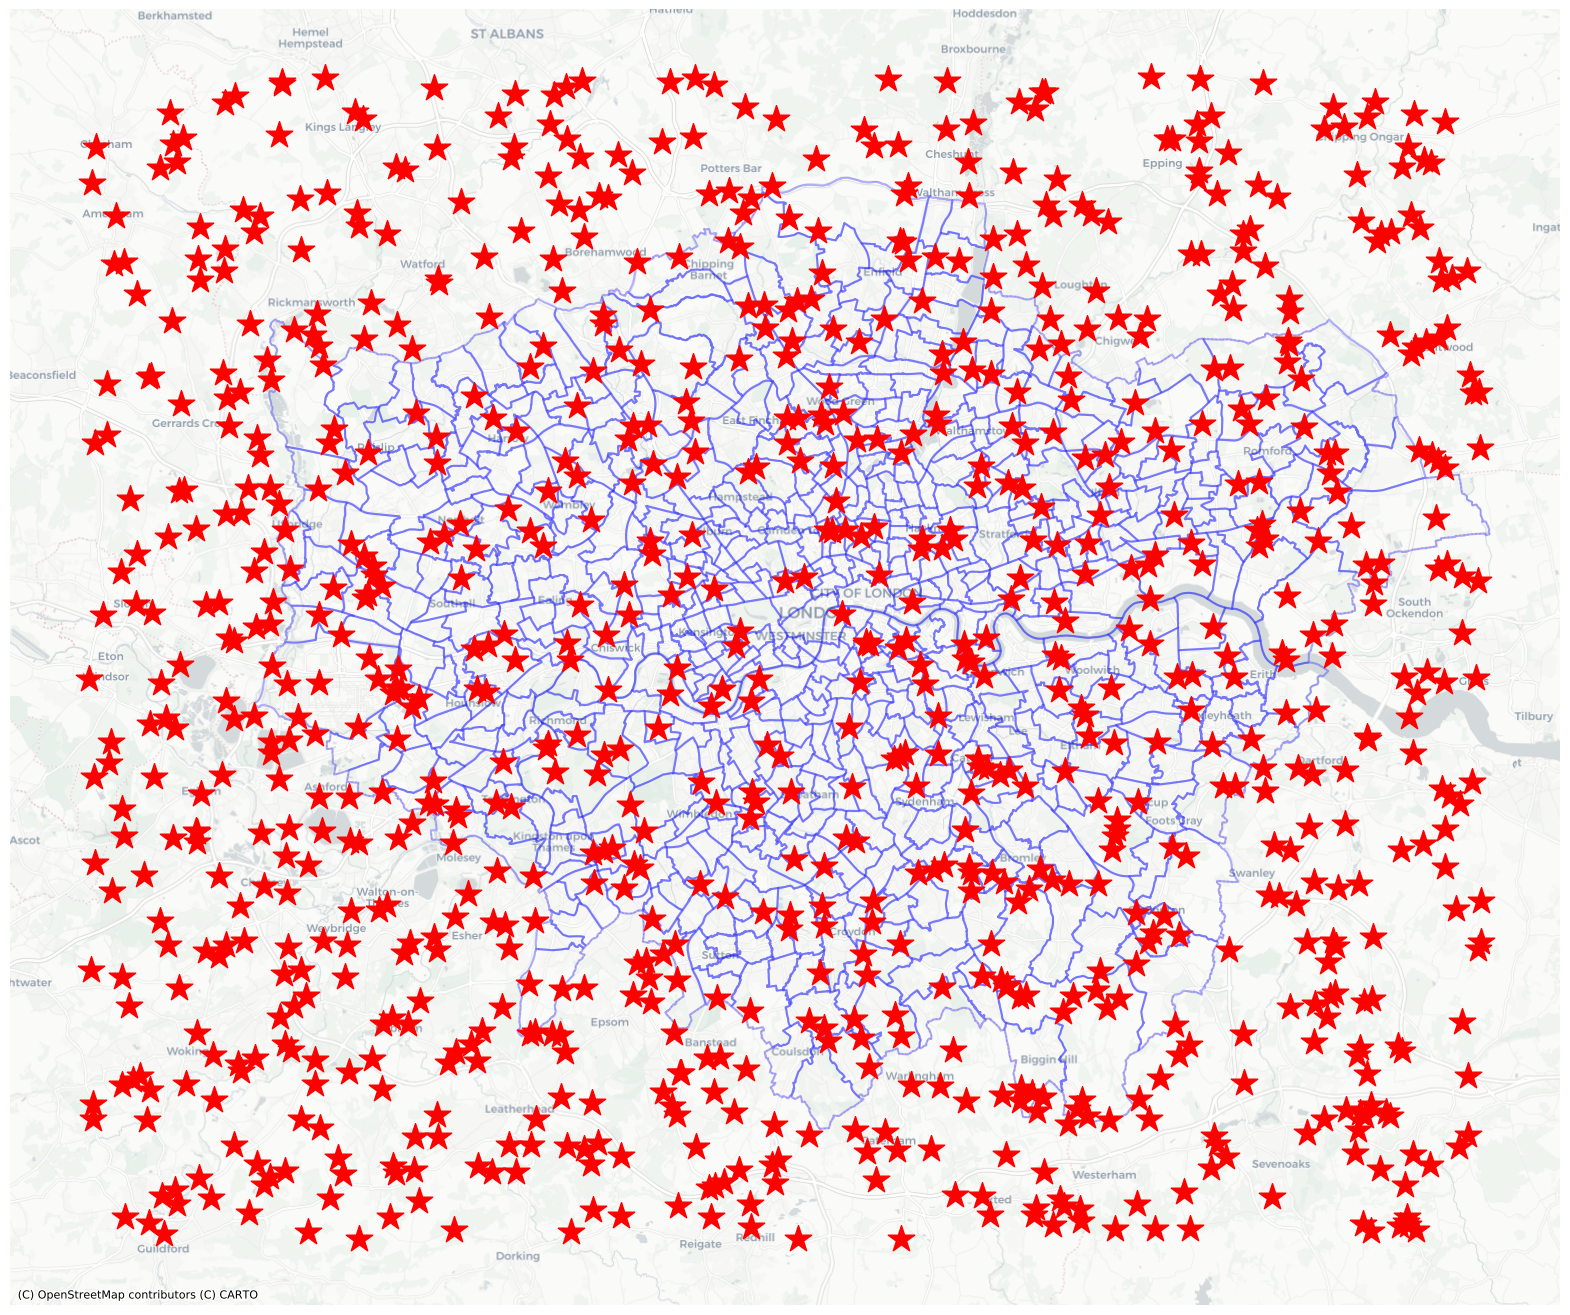

In [101]:
makeLayeredMap(london_map, gdf)